# Imports

Import section contain three parts:


1.   connecting to google drive
2.   import packages
3.   access input and folder- contains all input maps for the statistical model.



In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import glob
import pandas as pd
import numpy as np
from osgeo import gdal
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [3]:
fold_name = input('Enter Folder Name:\n')

path = '/content/gdrive/MyDrive/MicroDrone/'
fold_path = f'{path}/{fold_name}'

Enter Folder Name:
RF_CorrectionModel


The input folder arranges as followed:


*   IR_fixed folder >> real thermal measurements files.
*   physical_model folder >> physical prediction files.
*   cropped_maps folder >> contain subfolders with flight's input data



# Model Class

We wrote the model as a python class, with the functions below:
* init function - create dataframe with paths for each variable.
* split data function - splitting data into train and test sets (based on prior classification).
* trainRF - model training.
* test - for each map in the test set, calculate the coeerction map and save it in npy format.

In [4]:
class M2():

    def __init__(self, path, name, map_size = 1_024):
        '''
        Create model class.
        At initiation - create dataframe that contain all paths to input maps
        '''
        X_path = path + '/cropped_maps/'
        y_path = path + '/physical_model'

        self.name = name
        self.N = map_size
        self.features = ['TGI', 'height', 'shade', 'real_solar', 'skyview']

        files_dict = {'IR':[], 'TGI':[], 'height':[], 'shade':[], 'real_solar':[], 'skyview':[]}
        temp_list = glob.glob(f'{y_path}/*.tif')
        temp_list.sort()
        files_dict['M1'] = temp_list
        flights = [f.split('/')[-1][:-6] for f in temp_list]
        files_dict['Flight'] = flights
        for name in np.unique(flights):
            for feature in self.features:
              temp_list = glob.glob(f'{X_path}/{name}/{feature}_*.tif')
              temp_list.sort()
              files_dict[feature] += temp_list
            temp_list = glob.glob(f'{path}/IR_fixed/{name}*.npy')
            temp_list.sort()
            files_dict['IR'] += temp_list

        self.files_df = pd.DataFrame(files_dict)

    def split_data(self, pixels, train_set_maps):
        '''
        Create dataframe for random forest model.
        For each map within the train set maps, and for each crop at those maps,
        the script takes [pixels] random pixels.
        '''
        self.train_flights = pd.Series(train_set_maps)
        self.len_of_random_pix = pixels

        masks = {}
        dctRF = {'PredM1': [], 'PredErrorM1':[],
               'TGI': [], 'Height': [], 'Shade': [], 'RealSolar': [], 'Skyview': [],
               }

        for flight in self.train_flights:
            subset = self.files_df[self.files_df['Flight'] == flight].reset_index()
            for crop in range(len(subset)):
                rand = np.random.randint(0,self.N**2, pixels) # list of random indexes from the map
                m = np.zeros((self.N,self.N)).flatten()
                m[rand] = 1
                masks[f'{flight}_{crop}'] = m.reshape((self.N, self.N))

                dctRF['TGI'] += list(gdal.Open(subset['TGI'][crop]).ReadAsArray().flatten()[rand])
                dctRF['Height'] += list(gdal.Open(subset['height'][crop]).ReadAsArray().flatten()[rand])
                dctRF['Shade'] += list(gdal.Open(subset['shade'][crop]).ReadAsArray().flatten()[rand])
                dctRF['RealSolar'] += list(gdal.Open(subset['real_solar'][crop]).ReadAsArray().flatten()[rand])
                dctRF['Skyview'] += list(gdal.Open(subset['skyview'][crop]).ReadAsArray().flatten()[rand])

                pred_m1 = gdal.Open(subset['M1'][crop]).ReadAsArray().flatten()[rand]
                dctRF['PredM1'] += list(pred_m1)

                pred_error_m1 = gdal.Open(subset['M1'][crop]).ReadAsArray().flatten()[rand] - \
                    np.load(subset['IR'][crop]).flatten()[rand] - 273.16
                dctRF['PredErrorM1'] += list(pred_error_m1 - np.nanmean(pred_error_m1)) # centralized to calculate the residuals

        train_df_rf = pd.DataFrame(dctRF)
        train_df_rf = train_df_rf.dropna()
        train_df_rf = train_df_rf.reset_index()
        self.RF_train_df = train_df_rf

        self.mask = masks

    def trainRF(self, plot = False):
        '''
        run basic random forest pipeline on the training data.
        '''
        X = self.RF_train_df.drop(['index', 'PredErrorM1'],1)
        y = self.RF_train_df['PredErrorM1']

        rf_model = RandomForestRegressor(random_state=42, n_estimators = 100, max_depth=10)
        rf_model.fit(X, y)
        y_pred = rf_model.predict(X)
        r2_RF = r2_score(y, y_pred)
        importance = rf_model.feature_importances_
        importance_df = pd.DataFrame({'feature': X.columns, 'coefficient': importance})
        self.RFModel = rf_model
        self.feature_importances = importance_df
        self.trainedR2_RF = r2_RF

        print(f'r^2:\tRF = {r2_RF:.3f}')

        if plot:
            rand = np.random.randint(0, len(y), 1000)
            sns.regplot(x = y[rand], y = y_pred[rand])
            plt.ylabel('Predicted')
            plt.xlabel('Real')
            plt.title('RF model')
            plt.show()

    def test(self, path):
        '''
        for maps in test set (not in train set), the function create dataframe from
        input maps and run the model.
        '''
        for flight in self.files_df['Flight'].unique():
            if flight in list(self.train_flights):
                continue
            subset = self.files_df[self.files_df['Flight'] == flight].reset_index()
            for crop, sub_flight in enumerate(subset['M1']):
                name = sub_flight.split('/')[-1][:-4]
                tgi = gdal.Open(subset['TGI'][crop]).ReadAsArray().flatten()
                height = gdal.Open(subset['height'][crop]).ReadAsArray().flatten()
                shade = gdal.Open(subset['shade'][crop]).ReadAsArray().flatten()
                real_solar = gdal.Open(subset['real_solar'][crop]).ReadAsArray().flatten()
                skyview = gdal.Open(subset['skyview'][crop]).ReadAsArray().flatten()
                pred_m1 = gdal.Open(subset['M1'][crop]).ReadAsArray().flatten()

                dataRF = pd.DataFrame({'PredM1':pred_m1,
                                     'TGI':tgi, 'Height':height,
                                     'Shade':shade, 'RealSolar':real_solar, 'Skyview':skyview})

                m2_map = self.RFModel.predict(dataRF).reshape((self.N, self.N))
                np.save(f'{path}/{name}_Model_RF.npy', m2_map)

# Run the Model

In [5]:
train_maps = "Zeelim_29.5.19_0830,Zeelim_29.5.19_1650,Zeelim_29.5.19_1730,Zeelim_30.5.19_0600,Zeelim_30.5.19_0630,Zeelim_18.9.19_0900,Zeelim_18.9.19_1200,Zeelim_18.9.19_1300,Zeelim_18.9.19_1400,Zeelim_18.9.19_1500,Zeelim_18.9.19_1720,Zeelim_7.11.19_1030,Zeelim_7.11.19_1100,Zeelim_7.11.19_1310,Zeelim_7.11.19_1550,Zeelim_7.11.19_1640,Zeelim_30.1.20_0810,Zeelim_30.1.20_0920,Zeelim_30.1.20_0950,Zeelim_30.1.20_1050,Zeelim_30.1.20_1200,Zeelim_30.1.20_1300,Zeelim_30.1.20_1350,Zeelim_30.1.20_1449,Zeelim_30.1.20_1523"
train_set = train_maps.split(',')

In [6]:
model2 = M2('/content/gdrive/MyDrive/MicroDrone/', 'M2')

<ipython-input-4-f924c4d2b9ac>:78: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = self.RF_train_df.drop(['index', 'PredErrorM1'],1)


r^2:	RF = 0.700


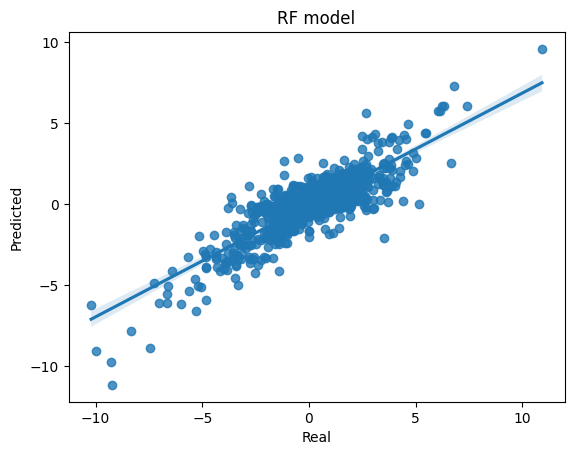

In [7]:
model2.split_data(1_000, train_set)

model2.trainRF(plot = True)

In [8]:
try:
    os.mkdir(fold_path)
except:
    pass

model2.test(fold_path)

with open(f'{fold_path}/m2.pkl', 'wb') as handle:
    pickle.dump(model2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Create Summary DF

In [9]:
files = glob.glob(fold_path + '/*RF.npy')
d = {'Map':[],
     'M1_ME': [], 'M2_ME': [],
     'M1_MAE': [], 'M2_MAE': [],
     'M1_STD': [], 'M2_STD': [],
     'M1_MAD': [], 'M2_MAD': []
     }
for t4 in files:
    name = t4.split('/')[-1][:-13]
    try:
      t1 = glob.glob(f'/content/gdrive/MyDrive/MicroDrone/physical_model/{name}*')[0]
      m2 = glob.glob(f'{fold_path}/{name}_Model_RF.npy')[0]
      fir = glob.glob(f'/content/gdrive/MyDrive/MicroDrone/IR_fixed/{name}*')[0]
      tgi = glob.glob(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/TGI_{name[-1]}.tif')[0]
    except:
      print(t4)
      continue

    t1_map = gdal.Open(t1).ReadAsArray() # tf.imread(t1)
    m2_map = np.load(m2)
    fir_map = np.load(fir) + 273.16
    tgi_map = gdal.Open(tgi).ReadAsArray() # tf.imread(tgi)

    t1_map[tgi_map > 0.04] = np.nan
    m2_map[tgi_map > 0.04] = np.nan
    fir_map[tgi_map > 0.04] = np.nan

    if np.nanmean(t1_map - fir_map) > 1_000:
        continue

    d['Map'].append(name)

    d['M1_ME'].append(np.nanmean(t1_map - fir_map))
    d['M1_MAE'].append(np.nanmean(abs(t1_map - fir_map)))
    d['M1_STD'].append(np.nanstd(t1_map - fir_map))
    d['M1_MAD'].append(np.nanstd(abs(t1_map - fir_map)))

    d['M2_ME'].append(np.nanmean((t1_map - m2_map - fir_map)))
    d['M2_MAE'].append(np.nanmean(abs(t1_map - m2_map - fir_map)))
    d['M2_STD'].append(np.nanstd((t1_map - m2_map - fir_map)))
    d['M2_MAD'].append(np.nanstd(abs(t1_map - m2_map - fir_map)))

df = pd.DataFrame(d)

df.to_csv(f'{fold_path}/physical_results_{fold_name}.csv')

# Summary Results

In [10]:
df['Flight'] = df["Map"].apply(lambda x: pd.Series(str(x)[:-2]))

df[['Flight', 'M1_ME', 'M2_ME', 'M1_MAE', 'M2_MAE']].groupby('Flight').mean()

,M1_ME,M2_ME,M1_MAE,M2_MAE
Flight,,,,
Zeelim_12.04.21_1118,2.980275,0.648585,3.922127,1.455611
Zeelim_23.9.19_0610,-0.319208,0.164882,1.812875,0.942535
Zeelim_23.9.19_0700,2.453162,2.251619,2.696448,2.561578
Zeelim_23.9.19_0800,1.040028,0.078863,2.326060,1.232861
Zeelim_23.9.19_1410,-2.067625,-2.598172,3.046987,2.674058
Zeelim_23.9.19_1510,-1.520961,-2.093882,2.419499,2.261738
Zeelim_23.9.19_1610,-0.331118,-1.663557,1.673840,2.006230
Zeelim_31.05.21_1516,1.684178,-1.264487,2.761611,1.610925
Zeelim_31.05.21_1712,2.965531,1.712154,3.295847,2.003251


In [11]:
df

,Map,M1_ME,M2_ME,M1_MAE,M2_MAE,M1_STD,M2_STD,M1_MAD,M2_MAD,Flight
0,Zeelim_12.04.21_1118_1,3.150393,0.794867,3.923248,1.402859,3.810097,1.562720,3.008311,1.051614,Zeelim_12.04.21_1118
1,Zeelim_12.04.21_1118_2,3.456302,0.958075,4.139734,1.534673,3.837955,1.653249,3.088449,1.138384,Zeelim_12.04.21_1118
2,Zeelim_12.04.21_1118_3,2.060523,0.155631,3.323783,1.374003,3.841167,1.765921,2.820068,1.120185,Zeelim_12.04.21_1118
3,Zeelim_12.04.21_1118_4,3.549666,0.470219,4.493063,1.457752,4.042702,1.803776,2.959045,1.161753,Zeelim_12.04.21_1118
4,Zeelim_12.04.21_1118_5,2.684493,0.864132,3.730805,1.508768,3.881483,1.612553,2.890243,1.034733,Zeelim_12.04.21_1118
5,Zeelim_23.9.19_0610_1,0.817523,0.603703,1.530675,0.924391,1.630510,0.942443,0.991938,0.630997,Zeelim_23.9.19_0610
6,Zeelim_23.9.19_0610_2,0.188606,0.434666,1.582425,1.006808,1.980295,1.204332,1.205433,0.791004,Zeelim_23.9.19_0610
7,Zeelim_23.9.19_0610_3,-0.068774,-0.269168,0.947906,0.806431,1.427519,1.022757,1.069586,0.684216,Zeelim_23.9.19_0610
8,Zeelim_23.9.19_0610_4,-0.670533,0.154421,2.234139,1.074887,2.640196,1.360969,1.558484,0.848940,Zeelim_23.9.19_0610
9,Zeelim_23.9.19_0610_5,-1.862864,-0.099210,2.769232,0.900157,2.472415,1.114839,1.383638,0.665151,Zeelim_23.9.19_0610
